Data Processing for Flurometer (for Chlorophyll Concentration)

In [1]:
import numpy as np
from numpy import genfromtxt
import ciso8601
import time
import datetime
import json
import pandas as pd
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from sklearn.preprocessing import StandardScaler

/home/pasindu/miniconda3/envs/matplot/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
fluoro_timestamp = genfromtxt('unix_dataset/uwu.txt', dtype='str',delimiter='\t')
fluoro_data = genfromtxt('unix_dataset/uwu.txt',delimiter='\t')
timestamp = fluoro_timestamp[:,0]
raw_fluoro = fluoro_data[:,3]
proc_fluoro = []
unix_time = []
#Calibration data according to manufacturer 
scale = 0.0073
dark_count = 45
#Extract fluoroescence count and convert to chlorophyll concentration, then convert date to unix epoch
for item in raw_fluoro:
    proc_val = scale*(item-dark_count)
    if proc_val>0:
        proc_fluoro.append(proc_val)
    else:
        proc_fluoro.append(0.00001)
for timeuwu in timestamp:
    s = timeuwu.split(',')
    ss = s[0].split('.')
    ts = ciso8601.parse_datetime(s[0])
    bruh = time.mktime(ts.timetuple())
    
    
    bruh_int = int(bruh)
    unix_time.append(bruh_int)
    #print(bruh_int)



Plot chlorophyll concentration along transect

In [3]:
#Obtain coordinate data from JSON file
# Load the JSON file
with open('unix_dataset/seapath.json', 'r') as file:
    data = json.load(file)

# Extract coordinates
coordinates = data['features'][0]['geometry']['coordinates']
time = data['features'][0]['properties']['coordTimes']
# Separate longitude and latitude
longitudes = [coord[0] for coord in coordinates]
latitudes = [coord[1] for coord in coordinates]

#Save to pandas dataframe for lookup
coord_frame = pd.DataFrame({'time':time, 'long':longitudes, 'lat':latitudes})
chloro_frame = pd.DataFrame({'time':unix_time, 'chloro':proc_fluoro})

coord_frame['time'] = pd.to_datetime(coord_frame['time'], unit='ms')
chloro_frame['time'] = pd.to_datetime(chloro_frame['time'], unit='s')

coord_filt = coord_frame[coord_frame['time'].dt.minute.isin([0,30])]
chloro_filt = chloro_frame[chloro_frame['time'].dt.minute.isin([0,30])]
chloro_second_filt = chloro_filt[chloro_filt['time'].dt.second.isin([0])]

print(coord_filt)
print(chloro_second_filt)

#Merge coordinate and chlorophyll concentration data
merged_data = coord_filt.merge(chloro_second_filt, on='time')
print(merged_data)
#FINALLYYYYYYYYYYYYYYYYYYYYYYYYYY
merged_data['chloro'] = np.log10(merged_data['chloro'])  #for better chlorophyll processing

                    time       long       lat
29   2025-01-07 00:30:00  73.503999  4.277357
59   2025-01-07 01:00:00  73.504082  4.277379
89   2025-01-07 01:30:00  73.503959  4.277171
119  2025-01-07 02:00:00  73.503902  4.277039
149  2025-01-07 02:30:00  73.504038  4.277264
...                  ...        ...       ...
8610 2025-01-12 23:30:00  57.805635 -5.525789
8640 2025-01-13 00:00:00  57.724210 -5.579305
8670 2025-01-13 00:30:00  57.643327 -5.632450
8700 2025-01-13 01:00:00  57.561943 -5.685926
8730 2025-01-13 01:30:00  57.480696 -5.739485

[292 rows x 3 columns]
                      time   chloro
0      2025-01-07 20:00:00  0.00001
1689   2025-01-07 20:30:00  0.00001
5072   2025-01-07 21:30:00  0.00001
6763   2025-01-07 22:00:00  0.00001
8454   2025-01-07 22:30:00  0.00001
...                    ...      ...
412670 2025-01-12 22:00:00  0.00001
414362 2025-01-12 22:30:00  0.00001
416053 2025-01-12 23:00:00  0.00001
417745 2025-01-12 23:30:00  0.00001
419436 2025-01-13 00:00:00  

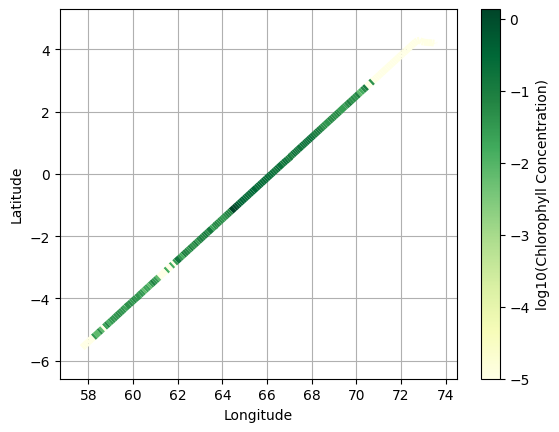

In [4]:

long = merged_data['long']
lat = merged_data['lat']
chloro = merged_data['chloro']

#Plotting of chlorophyll concentration variety along transect
def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """
    x = long
    y = lat
    z = chloro
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='YlGn',norm=plt.Normalize(z.min(),z.max()))
    plt.colorbar(lc, label="log10(Chlorophyll Concentration)")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('chlorophyll.png')
    plt.show()

def colorline(
        x, y, z=None, cmap='hot', norm=plt.Normalize(0.0, 1.0),
        linewidth=5, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

multicolored_lines()

                   time       long       lat     temp
0   2025-01-09 04:00:00  70.274682  2.679667  20.7171
1   2025-01-09 04:00:00  70.273163  2.678648  20.7171
2   2025-01-09 04:30:00  70.183158  2.619343  20.8429
3   2025-01-09 05:00:00  70.091905  2.559271  21.0107
4   2025-01-09 05:30:00  70.001488  2.499747  28.9875
..                  ...        ...       ...      ...
172 2025-01-12 17:30:00  58.802095 -4.869721  28.0510
173 2025-01-12 18:00:00  58.721056 -4.923159  28.1849
174 2025-01-12 18:30:00  58.638279 -4.977656  28.1716
175 2025-01-12 19:00:00  58.556539 -5.031405  28.2337
176 2025-01-12 19:30:00  58.474643 -5.085353  28.1823

[177 rows x 4 columns]


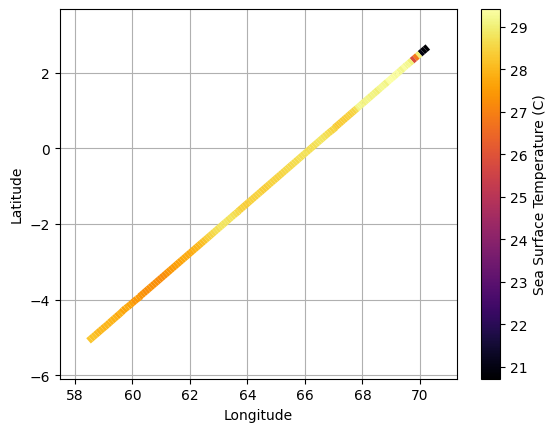

In [5]:
#Load Temperature Data
temp_data = genfromtxt("unix_dataset/temp.csv", delimiter=',')
temp_frame = pd.DataFrame({'time':temp_data[:,0], 'temp':temp_data[:,1]})
temp_frame['time'] = pd.to_datetime(temp_frame['time'], unit='ms')
temp_filt = temp_frame[temp_frame['time'].dt.minute.isin([0,30])]

#Log Operation to visualise changes better

merge_temp = coord_filt.merge(temp_filt, on='time')
print(merge_temp)

def temp_plot():
    x = merge_temp['long']
    y = merge_temp['lat']
    z = merge_temp['temp']
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='inferno',norm=plt.Normalize(z.min(),z.max()))
    plt.colorbar(lc, label="Sea Surface Temperature (C)")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('temp.png')
    plt.show()


temp_plot()


                   time       long       lat   saline
0   2025-01-09 05:30:00  70.001488  2.499747  34.1488
1   2025-01-09 06:00:00  69.910092  2.439626  34.0852
2   2025-01-09 06:30:00  69.817312  2.378420  34.0555
3   2025-01-09 07:00:00  69.722643  2.316131  34.1420
4   2025-01-09 07:30:00  69.628098  2.253875  33.6239
..                  ...        ...       ...      ...
168 2025-01-12 17:30:00  58.802095 -4.869721  34.7207
169 2025-01-12 18:00:00  58.721056 -4.923159  34.7074
170 2025-01-12 18:30:00  58.638279 -4.977656  34.7157
171 2025-01-12 19:00:00  58.556539 -5.031405  34.7144
172 2025-01-12 19:30:00  58.474643 -5.085353  34.7153

[173 rows x 4 columns]


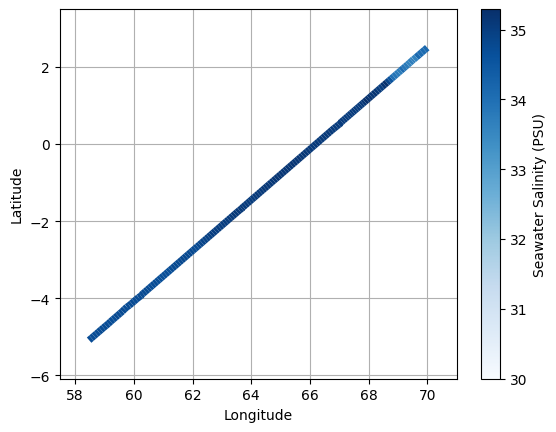

In [6]:
#Load Salinity Data
saline_data = genfromtxt("unix_dataset/salinity.csv", delimiter=',')
saline_frame = pd.DataFrame({'time':saline_data[:,0], 'saline':saline_data[:,1]})
saline_frame['time'] = pd.to_datetime(saline_frame['time'], unit='ms')
saline_filt = saline_frame[saline_frame['time'].dt.minute.isin([0,30])]

merge_saline = coord_filt.merge(saline_filt, on='time')
print(merge_saline)

def saline_plot():
    x = merge_saline['long']
    y = merge_saline['lat']
    z = merge_saline['saline']
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='Blues',norm=plt.Normalize(30,z.max()))
    plt.colorbar(lc, label="Seawater Salinity (PSU)")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('saline.png')
    plt.show()


saline_plot() 

                   time       long       lat     count     coeff
0   2025-01-09 08:30:00  69.532113  2.193306  0.782664  0.061263
1   2025-01-09 09:00:00  69.531267  2.194019  0.783140  0.061111
2   2025-01-09 09:30:00  69.529793  2.194882  0.771002  0.065016
3   2025-01-09 10:00:00  69.529793  2.194901  0.777942  0.062776
4   2025-01-09 10:30:00  69.529786  2.194898  0.779514  0.062271
..                  ...        ...       ...       ...       ...
174 2025-01-12 23:30:00  57.805635 -5.525789  0.726067  0.080028
175 2025-01-13 00:00:00  57.724210 -5.579305  0.727887  0.079402
176 2025-01-13 00:30:00  57.643327 -5.632450  0.727574  0.079510
177 2025-01-13 01:00:00  57.561943 -5.685926  0.728259  0.079275
178 2025-01-13 01:30:00  57.480696 -5.739485  0.727727  0.079457

[179 rows x 5 columns]


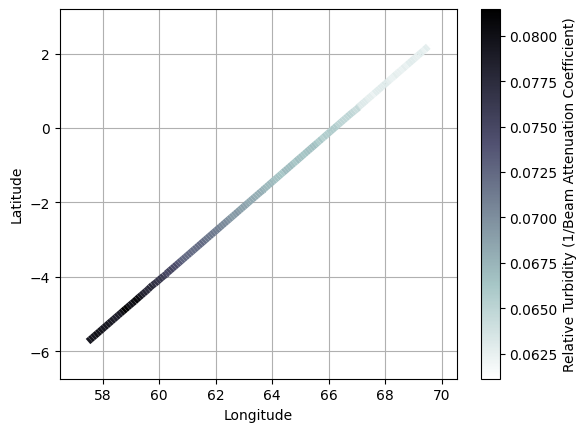

In [31]:
#Obtaining Turbidity through beam attenuation coefficient and Transmissivity
trans_data = genfromtxt('unix_dataset/trans.csv', delimiter=',')
trans_frame = pd.DataFrame({'time':trans_data[:,0], 'count':trans_data[:,1]})
trans_frame['time'] = pd.to_datetime(trans_frame['time'], unit='ms')
trans_filt = trans_frame[trans_frame['time'].dt.minute.isin([0,30])]

#Process the digital counts to obtain beam coefficient
ref_count = 15345
pathlen = 0.25


merge_trans = coord_filt.merge(trans_filt, on='time')
merge_trans['count'] /= ref_count
merge_trans['coeff'] = -1/(pathlen*np.log(merge_trans['count']))
merge_trans['coeff'] = 1/merge_trans['coeff']
print(merge_trans)

def trans_plot():
    x = merge_trans['long']
    y = merge_trans['lat']
    z = merge_trans['coeff']
    fig, ax = plt.subplots()
    lc = colorline(x, y, z, cmap='bone_r',norm=plt.Normalize(z.min(),z.max()))
    plt.colorbar(lc, label="Relative Turbidity (1/Beam Attenuation Coefficient)")
    plt.xlim(x.min()-1, x.max()+1)
    plt.ylim(y.min()-1, y.max()+1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid()
    plt.savefig('trans.png')
    plt.show()


trans_plot() 


In [38]:
#Attempt at Redundancy Analysis (RDA)
test_series = merge_temp['temp']
#print(test_series)

chloro_temp = merge_temp.merge(chloro_filt, on='time')
chloro_saline = merge_saline.merge(chloro_filt, on='time')
chloro_trans = merge_trans.merge(chloro_filt, on='time')

#print(chloro_temp)
#print(chloro_saline)
#print(chloro_trans)

merge_indep = chloro_temp.merge(chloro_saline[['time', 'saline']], on='time')
merge_indep = merge_indep.merge(chloro_trans[['time', 'coeff']], on='time')
collection = pd.concat([chloro_temp['temp'], chloro_saline['saline'], chloro_trans['coeff']], axis=1)
chloro_agg = pd.concat([chloro_temp['chloro'], chloro_saline['chloro'], chloro_trans['chloro']], axis=1)
collection = collection[collection['saline'].notna()]
chloro_agg = chloro_agg[chloro_agg.iloc[:,1].notna()]
collection = np.log(collection)
chloro_agg = np.log(chloro_agg)
print(collection)
print(chloro_agg)
collection.to_csv('explanatory_matrix.csv')
chloro_agg.to_csv('response_matrix.csv')
#print(merge_indep)
#indep_vars = merge_indep[['temp', 'saline', 'coeff']]
#dep_vars = merge_indep[['chloro', 'chloro', 'chloro']]
#print(indep_vars)
#print(dep_vars)
#indep_vars.to_csv('explanatory_matrix.csv')
#dep_vars.to_csv('response_matrix.csv')
#Convert to numpy
#indep_arr = indep_vars.to_numpy()
#dep_arr = dep_vars.to_numpy()
#print(indep_arr)
#print(dep_arr)

         temp    saline     coeff
0    3.030959  3.530727 -2.792578
1    3.030959  3.528863 -2.795066
2    3.037013  3.527992 -2.733120
3    3.045032  3.530528 -2.768188
4    3.366865  3.515237 -2.776259
..        ...       ...       ...
156  3.331633  3.547336 -2.534629
157  3.329945  3.546953 -2.534473
158  3.332394  3.547192 -2.536178
159  3.331569  3.547155 -2.532158
160  3.334024  3.547181 -2.530210

[161 rows x 3 columns]
       chloro     chloro     chloro
0   -4.226734  -3.310443  -2.354932
1   -4.226734  -2.973971  -2.354932
2   -4.919881  -3.128121  -3.821269
3   -2.521986  -2.434974  -3.533587
4   -3.310443  -2.973971  -3.310443
..        ...        ...        ...
156 -3.310443  -3.821269 -11.512925
157 -3.533587 -11.512925 -11.512925
158 -4.226734  -4.919881 -11.512925
159 -2.840439  -3.128121 -11.512925
160 -3.821269  -4.919881 -11.512925

[161 rows x 3 columns]


In [14]:
from functools import reduce
#obtain common timestamps for chlorophyll data
merged_base = reduce(lambda x,y: pd.merge(x,y, on='time', how='outer'), [merge_temp[['time','temp']], merge_saline[['time','saline']], merge_trans[['time','coeff']]])
print(merged_base)

chloro_merge = merged_base

                   time     temp   saline      coeff
0   2025-01-09 04:00:00  20.7171      NaN        NaN
1   2025-01-09 04:00:00  20.7171      NaN        NaN
2   2025-01-09 04:30:00  20.8429      NaN        NaN
3   2025-01-09 05:00:00  21.0107      NaN        NaN
4   2025-01-09 05:30:00  28.9875  34.1488        NaN
..                  ...      ...      ...        ...
184 2025-01-12 23:30:00      NaN      NaN  12.495582
185 2025-01-13 00:00:00      NaN      NaN  12.594079
186 2025-01-13 00:30:00      NaN      NaN  12.577055
187 2025-01-13 01:00:00      NaN      NaN  12.614394
188 2025-01-13 01:30:00      NaN      NaN  12.585393

[189 rows x 4 columns]


In [12]:
#screw this, using R on master's computer instead
def perform_rda(X, Y):
    # Standardize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    X_std = scaler_x.fit_transform(X)
    Y_std = scaler_y.fit_transform(Y)
    
    # Step 1: Multiple Linear Regression
    # Calculate Y_fitted using the formula Y_fit = X(X'X)^(-1)X'Y
    X_transpose = np.transpose(X_std)
    X_square = np.linalg.inv(X_transpose.dot(X_std))
    Y_fitted = X_std.dot(X_square.dot(X_transpose.dot(Y_std)))
    
    # Step 2: PCA on fitted values
    # Calculate covariance matrix
    covariance_matrix = np.cov(Y_fitted.T)
    
    # Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Sort eigenvalues and eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate canonical axes (scores)
    canonical_axes = Y_fitted.dot(eigenvectors)
    
    return canonical_axes, eigenvalues, eigenvectors

canonical_axes, eigenvalues, eigenvectors = perform_rda(indep_arr, dep_arr)
print(eigenvectors)

[[ 0.57735027  0.         -0.81649658]
 [ 0.57735027 -0.70710678  0.40824829]
 [ 0.57735027  0.70710678  0.40824829]]
